# Análisis Exploratorio de Datos (EDA)

### Resultados de Fútbol y Cuotas de Apuestas

Este EDA tiene como objetivo analizar:

- La distribución de goles locales y visitantes.
- El impacto de jugar en casa.
- La frecuencia de resultados (H, D, A).
- La relación entre cuotas (`AvgH`, `AvgD`, `AvgA`) y resultados reales.
- Supuestos clave para modelar goles con **distribuciones de Poisson**.

El análisis sirve como base para construir modelos predictivos aplicables al mercado de apuestas deportivas.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Cargar el dataset
df = pd.read_csv("../datasets/combined_odds_cleaned.csv")

# Mostrar las primeras filas
df.head()

,Date,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,AvgH,AvgD,AvgA
0,2003-08-30,2003-04,Albacete,Osasuna,0,2,A,2.21,3.06,2.99
1,2003-08-30,2003-04,Ath Bilbao,Barcelona,0,1,A,2.64,3.13,2.42
2,2003-08-30,2003-04,Espanol,Sociedad,1,1,D,2.58,3.10,2.48
3,2003-08-30,2003-04,Malaga,Villarreal,0,0,D,2.27,3.08,2.88
4,2003-08-30,2003-04,Real Madrid,Betis,2,1,H,1.38,4.00,7.18


In [15]:
# Número de temporadas únicas
num_temporadas = df['Season'].nunique()
print("Número de temporadas:", num_temporadas)

# Número de equipos por temporada
equipos_por_temporada = df.groupby('Season')['HomeTeam'].nunique()
print("Número de equipos por temporada:")
print(equipos_por_temporada)

# Número total de partidos
num_partidos_totales = len(df)
print("Número total de partidos:", num_partidos_totales)

# Número de partidos por temporada
partidos_por_temporada = df.groupby('Season').size()
print("Número de partidos por temporada:")
print(partidos_por_temporada)

Número de temporadas: 21
Número de equipos por temporada:
Season
2003-04    20
2004-05    20
2005-06    20
2006-07    20
2007-08    20
2008-09    20
2009-10    20
2010-11    20
2011-12    20
2012-13    20
2013-14    20
2014-15    20
2015-16    20
2016-17    20
2017-18    20
2018-19    20
2019-20    20
2020-21    20
2021-22    20
2022-23    20
2023-24    20
Name: HomeTeam, dtype: int64
Número total de partidos: 7980
Número de partidos por temporada:
Season
2003-04    380
2004-05    380
2005-06    380
2006-07    380
2007-08    380
2008-09    380
2009-10    380
2010-11    380
2011-12    380
2012-13    380
2013-14    380
2014-15    380
2015-16    380
2016-17    380
2017-18    380
2018-19    380
2019-20    380
2020-21    380
2021-22    380
2022-23    380
2023-24    380
dtype: int64


### Distribución de Goles: Local vs Visitante

Este gráfico compara la distribución de goles marcados por los equipos locales (`FTHG`) y visitantes (`FTAG`) usando estimaciones de densidad (KDE).  
Permite observar si los equipos locales tienden a marcar más goles, lo que respalda la existencia de una ventaja al jugar en casa.


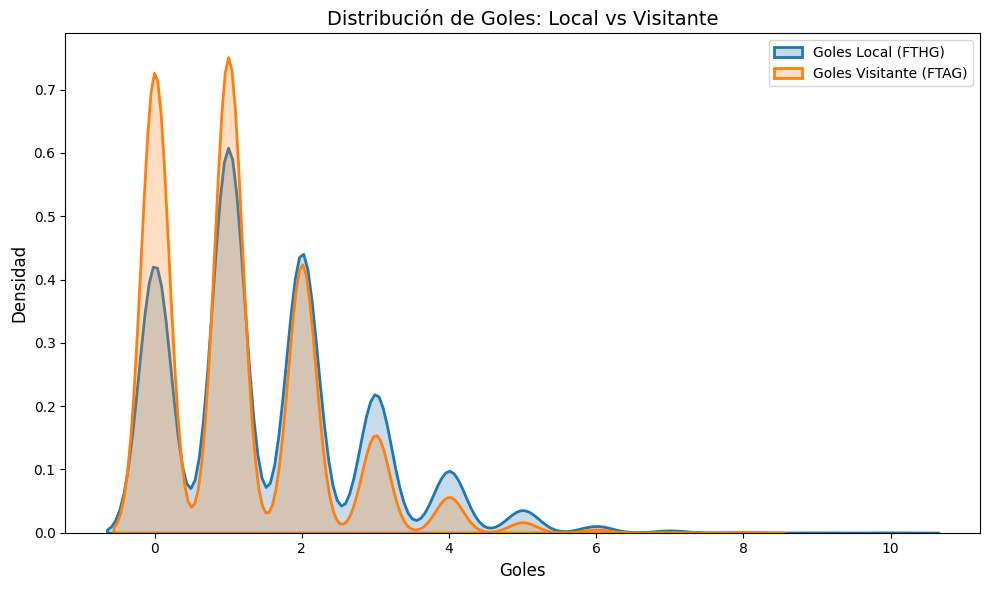

In [2]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['FTHG'], label="Goles Local (FTHG)", fill=True, linewidth=2)
sns.kdeplot(df['FTAG'], label="Goles Visitante (FTAG)", fill=True, linewidth=2)

plt.title("Distribución de Goles: Local vs Visitante", fontsize=14)
plt.xlabel("Goles", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


Los equipos **locales** tienden a marcar **más goles** que los visitantes.  
La distribución de goles está ligeramente desplazada hacia la derecha para los locales, lo que indica una **ventaja estadística al jugar en casa**.

Este patrón es clave para modelar los goles con una **distribución de Poisson diferenciada por localía**, y tiene implicaciones directas en la estimación de probabilidades y la evaluación de cuotas en el mercado de apuestas.


In [3]:
print("Promedio de goles como Local:", df['FTHG'].mean())
print("Promedio de goles como Visitante:", df['FTAG'].mean())


Promedio de goles como Local: 1.531203007518797
Promedio de goles como Visitante: 1.130075187969925


### Distribución de Resultados (FTR)

Este gráfico de barras muestra la proporción de partidos que terminan en victoria local (`H`), empate (`D`) o victoria visitante (`A`).  
Sirve para identificar qué tipo de resultado es más frecuente y detectar posibles sesgos, como la prevalencia de victorias locales.


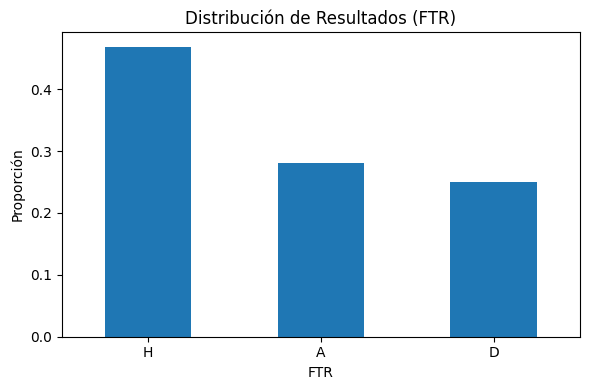

In [4]:
result_counts = df['FTR'].value_counts(normalize=True)
result_counts.plot(kind='bar', figsize=(6, 4), title='Distribución de Resultados (FTR)')
plt.ylabel("Proporción")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



La **victoria local (H)** es el resultado más frecuente, representando casi la mitad de los partidos.  
Los **empates (D)** y **victorias visitantes (A)** ocurren en proporciones similares pero claramente menores.

Este sesgo hacia el triunfo local refuerza la idea de **ventaja de jugar en casa**, y debe tenerse en cuenta al modelar resultados y calcular probabilidades para apuestas.

In [5]:
# Calcular y mostrar la correlación
cor = df[['FTHG', 'FTAG']].corr().iloc[0, 1]
print(f"Correlación entre goles locales y visitantes: {cor:.3f}")

Correlación entre goles locales y visitantes: -0.045


### Correlación entre Victoria Local y Goles

Se crea una variable binaria que indica si el equipo local ganó (`1`) o no (`0`).  
Luego se calcula su correlación con los goles del equipo local y visitante.  
Esto permite cuantificar cómo influye marcar o recibir goles en la probabilidad de ganar en casa.


In [11]:
# Crear variable binaria: victoria local = 1, otro resultado = 0
df['HomeWin'] = (df['FTR'] == 'H').astype(int)

# Correlación entre victoria local y goles anotados por el local
cor_hg = df[['HomeWin', 'FTHG']].corr().iloc[0, 1]
cor_ha = df[['HomeWin', 'FTAG']].corr().iloc[0, 1]

print(f"Correlación entre ganar en casa y goles locales: {cor_hg:.3f}")
print(f"Correlación entre ganar en casa y goles visitantes (negativa): {cor_ha:.3f}")

Correlación entre ganar en casa y goles locales: 0.635
Correlación entre ganar en casa y goles visitantes (negativa): -0.484



Ganar en casa se asocia fuertemente con **marcar más goles** (correlación = 0.635) y **recibir menos** (correlación = -0.484).  
Esto confirma que el rendimiento ofensivo y defensivo en casa es clave para obtener la victoria.

### Frecuencia Conjunta de Marcadores (Goles Local vs Visitante)

Se genera una tabla cruzada entre los goles locales (`FTHG`) y visitantes (`FTAG`) y se visualiza con un mapa de calor.  
Esto permite identificar los resultados más frecuentes y observar patrones en los marcadores reales de los partidos.


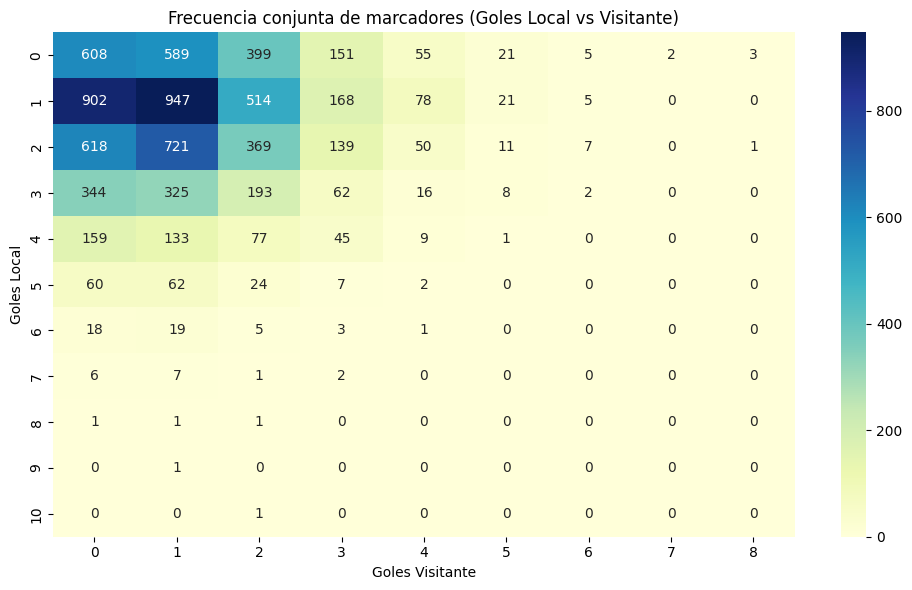

In [7]:
import numpy as np

# Crear tabla cruzada
heatmap_data = pd.crosstab(df['FTHG'], df['FTAG'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt='d')
plt.title("Frecuencia conjunta de marcadores (Goles Local vs Visitante)")
plt.xlabel("Goles Visitante")
plt.ylabel("Goles Local")
plt.tight_layout()
plt.show()


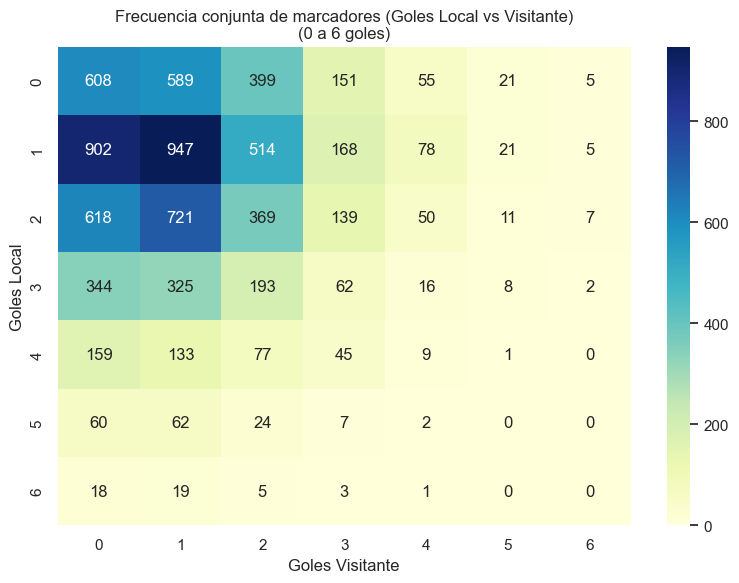

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar goles entre 0 y 6
df_filtrado = df[(df['FTHG'] <= 6) & (df['FTAG'] <= 6)]

# Crear tabla cruzada limitada
heatmap_data = pd.crosstab(df_filtrado['FTHG'], df_filtrado['FTAG'])

# Gráfico de calor
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt='d')

plt.title("Frecuencia conjunta de marcadores (Goles Local vs Visitante)\n(0 a 6 goles)")
plt.xlabel("Goles Visitante")
plt.ylabel("Goles Local")
plt.tight_layout()
plt.show()



La mayoría de los partidos terminan con **pocos goles**, siendo los resultados más comunes:
- 1-1
- 1-0
- 2-1
- 0-1

Los empates y victorias ajustadas dominan el centro del gráfico.  
Esto refuerza la idoneidad de usar **modelos de Poisson discretos y truncados** para capturar la dinámica realista de los marcadores, concentrados entre 0 y 3 goles por equipo.

### Distribución de Cuotas por Tipo de Resultado

En el gráfico se muestran las distribuciones de las cuotas promedio ofrecidas por las casas de apuestas para tres tipos de resultados:

- **Victoria Local** (`AvgH`)
- **Empate** (`AvgD`)
- **Victoria Visitante** (`AvgA`)

Cada curva representa la densidad de probabilidad estimada mediante un suavizado (KDE), restringida al rango de cuotas entre 0 y 15.


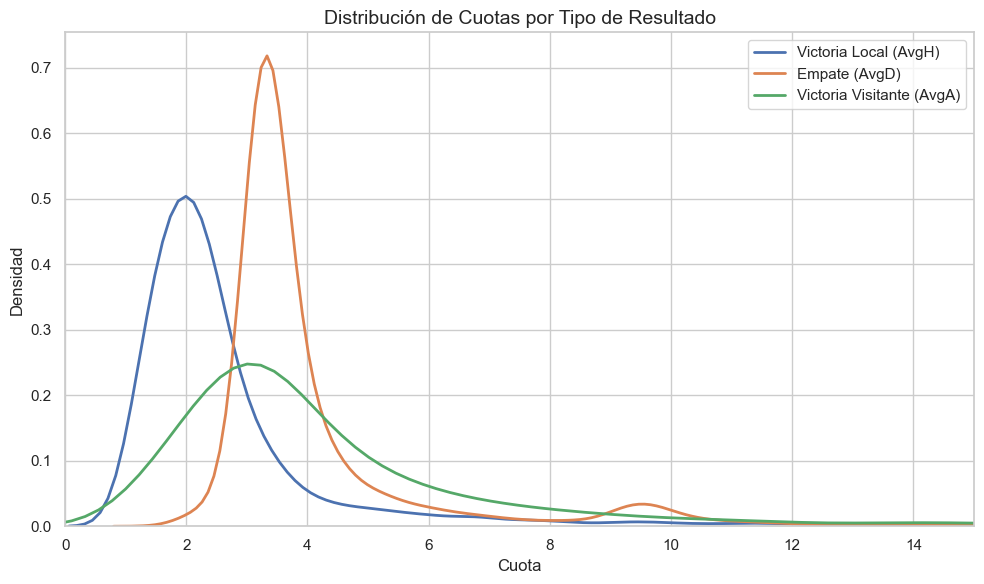

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv("../datasets/dataset_transformado.csv")

# Estilo del gráfico
sns.set(style="whitegrid")

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Distribución de cuotas por tipo de resultado
sns.kdeplot(df['AvgH'], label='Victoria Local (AvgH)', linewidth=2)
sns.kdeplot(df['AvgD'], label='Empate (AvgD)', linewidth=2)
sns.kdeplot(df['AvgA'], label='Victoria Visitante (AvgA)', linewidth=2)

# Títulos y formato
plt.title("Distribución de Cuotas por Tipo de Resultado", fontsize=14)
plt.xlabel("Cuota", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.xlim(0, 15)
plt.legend()
plt.tight_layout()
plt.show()



Las **cuotas de empate (`AvgD`)** están más concentradas y son generalmente **más altas** que las de victoria local (`AvgH`), pero **más bajas que muchas de visitante (`AvgA`)**.

Sin embargo, la curva de `AvgD` muestra una mayor densidad en el rango **3.0–4.0**, indicando que los empates son considerados **menos probables** por las casas de apuestas, aunque **no tan improbables como muchas victorias visitantes**.

Esto sugiere que el **empate actúa como resultado intermedio**: no es el más esperado, pero tampoco es tan inesperado como algunas sorpresas visitantes con cuotas superiores a 6–8.

In [16]:
# Cargar el dataset
df = pd.read_csv("../datasets/clasificaciones.csv")

# Mostrar las primeras filas
df.head()


,season,position,team,points,GD,GF,GA,num_matches
0,2003-04,1,Valencia,77,44,71,27,38
1,2003-04,2,Barcelona,72,24,63,39,38
2,2003-04,3,La Coruna,71,26,60,34,38
3,2003-04,4,Real Madrid,70,18,72,54,38
4,2003-04,5,Ath Bilbao,56,4,53,49,38


In [17]:
import pandas as pd

# Asegurarse de que la columna 'season' esté ordenada correctamente como string
df['season'] = df['season'].astype(str)

# Ordenar por equipo y temporada para facilitar el cálculo de diferencias
df_sorted = df.sort_values(by=['team', 'season'])

# Calcular la variación de posición entre temporadas consecutivas por equipo
df_sorted['position_diff'] = df_sorted.groupby('team')['position'].diff()

# Eliminar valores nulos (primera temporada de cada equipo)
df_diff = df_sorted.dropna(subset=['position_diff'])

# Calcular la variación absoluta promedio por equipo
team_variation = df_diff.groupby('team')['position_diff'].apply(lambda x: x.abs().mean())

# Resultado general: variación media de todos los equipos
media_variacion_global = team_variation.mean()

print(f"Variación media de posición entre temporadas consecutivas: {media_variacion_global:.2f}")

# (Opcional) Mostrar los equipos con más variación media
top_var = team_variation.sort_values(ascending=False).head(10)
print("\nTop 10 equipos con mayor variación media:")
print(top_var)


Variación media de posición entre temporadas consecutivas: 3.61

Top 10 equipos con mayor variación media:
team
Girona        7.666667
Albacete      6.000000
Recreativo    6.000000
Malaga        5.500000
Betis         5.411765
Mallorca      5.384615
Alaves        5.142857
Espanol       4.777778
Celta         4.642857
Elche         4.500000
Name: position_diff, dtype: float64


In [19]:
import pandas as pd

# Calcular goles a favor por equipo y temporada
# Como local
goles_local = df.groupby(['Season', 'HomeTeam'])['FTHG'].sum().reset_index()
goles_local.columns = ['Season', 'Team', 'Goals']

# Como visitante
goles_visitante = df.groupby(['Season', 'AwayTeam'])['FTAG'].sum().reset_index()
goles_visitante.columns = ['Season', 'Team', 'Goals']

# Unir goles totales
goles_totales = pd.concat([goles_local, goles_visitante])

# Sumar goles totales por equipo y temporada
goles_por_equipo = goles_totales.groupby(['Season', 'Team'])['Goals'].sum().reset_index()

# Ordenar para poder calcular diferencias
goles_por_equipo_sorted = goles_por_equipo.sort_values(by=['Team', 'Season'])

# Calcular variación de goles entre temporadas consecutivas
goles_por_equipo_sorted['Goals_diff'] = goles_por_equipo_sorted.groupby('Team')['Goals'].diff()

# Eliminar nulos (primera temporada)
goles_diff = goles_por_equipo_sorted.dropna(subset=['Goals_diff'])

# Calcular variación absoluta promedio por equipo
variacion_media_equipo = goles_diff.groupby('Team')['Goals_diff'].apply(lambda x: x.abs().mean())

# Resultado global
variacion_media_total = variacion_media_equipo.mean()

print(f"Variación media de goles anotados entre temporadas consecutivas: {variacion_media_total:.2f}")

# (Opcional) Equipos con más variación
print("\nTop 10 equipos con mayor variación media de goles:")
print(variacion_media_equipo.sort_values(ascending=False).head(10))


Variación media de goles anotados entre temporadas consecutivas: 8.07

Top 10 equipos con mayor variación media de goles:
Team
Girona         20.333333
Las Palmas     15.333333
Sociedad       10.352941
Betis          10.352941
Sevilla        10.100000
Recreativo     10.000000
Malaga          9.666667
Espanol         9.555556
Real Madrid     9.550000
Valencia        9.450000
Name: Goals_diff, dtype: float64
